### Example Analysis of a 2D R-Z Capillary Discharge Simulation

This notebook demonstrates a capillary discharge simulation analysis, using the 2D R-Z benchmark which we are developing. The test outputs are located in `outputs/cap-lin3/`

In [1]:
%matplotlib inline

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as const
import h5py
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

## Useful constants and conversions

In [2]:
#Useful constants and conversions

R = const.R # J/(mol K)
k = const.k #Joules per Kelvin
amu = const.m_u #amu in kG
na = const.N_A

K_2eV = const.physical_constants['Boltzmann constant in eV/K'][0]
eV_2K = 1./K_2eV

eV_2J = const.e
J_2eV = 1./eV_2J

Torr_2Ba = const.torr*10. #1333.22368
Ba_2Torr = 1./Torr_2Ba

atm_2Torr = const.atm/const.torr
Torr_2atm = 1./atm_2Torr

cgs_2kg = 1000.
kg_2cgs = 1/cgs_2kg

cgs_2num = 2.1496897992481925e+22

## Define some useful plot color schemes

In [3]:
####Define 20 set
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
    
####Define 10 set
tableau10 = [(31, 119, 180), (255, 127, 14),   
             (44, 160, 44), (214, 39, 40),   
             (148, 103, 189),(140, 86, 75),   
             (227, 119, 194), (127, 127, 127),  
             (188, 189, 34), (23, 190, 207)]  

for i in range(len(tableau10)):    
    r, g, b = tableau10[i]    
    tableau10[i] = (r / 255., g / 255., b / 255.)  

## Define folders

In [4]:
import fnmatch

#define root folder
fold = '/home/vagrant/jupyter/FLASH/FLASH4.5/outputs'

folds = [x[0] for x in os.walk(fold)]

folders = []
for st in folds:
    if fnmatch.fnmatch(st, '*/cap-*'):
        folders.append(st+'/')
        
#Specify the desired folder
curr_folder = folders[-3]
print curr_folder

/home/vagrant/jupyter/FLASH/FLASH4.5/outputs/cap-lin3/


### Reading in data from h5 plot files

The output files containing plot variables for these FLASH simulaitons is `capillary_hdf5_plt_cnt_INDEX`, where INDEX is the corresponding step number.

The following cells show which keys are immediately accessible from this file. For more information, see [Section 9 of the user guide](http://flash.uchicago.edu/site/flashcode/user_support/flash4_ug_4p5/node75.html#SECTION05291000000000000000).

In [5]:
#Specify file and construct file index
index = 100
#Folder + file heading
#f_dir = './Projects/Milchberg/run-b273d037/'
f_dir = curr_folder
f_prefix = 'capillary_hdf5_plt_cnt_'

run_num = f_dir[-9:-1] #grab the numeric identifier

zs = ['0' for ind in range(4-len(str(index)))]
pre = ''.join(zs)
f_ind = pre + str(index)

#file number is prepended by zeros to reach 4 digits
f_name = '{}{}{}'.format(f_dir,f_prefix,f_ind)
dFile = h5py.File(f_name)

dFile.keys()

[u'bflags',
 u'block size',
 u'bounding box',
 u'coordinates',
 u'dens',
 u'depo',
 u'fill',
 u'gid',
 u'gsurr_blks',
 u'integer runtime parameters',
 u'integer scalars',
 u'kapa',
 u'logical runtime parameters',
 u'logical scalars',
 u'magz',
 u'node type',
 u'processor number',
 u'real runtime parameters',
 u'real scalars',
 u'refine level',
 u'sim info',
 u'string runtime parameters',
 u'string scalars',
 u'sumy',
 u'tele',
 u'tion',
 u'trad',
 u'unknown names',
 u'velx',
 u'wall',
 u'which child',
 u'ye']

## Plot functions

Here are some simple plot functions for stacking lineouts of plot variables and other quantities

In [6]:
def plot_r_lineouts(nums, state, folder, sv=None):

    '''Plot state variable vs. r coordinate for multiple time steps of a FLASH simulation.
    Assumes that the simulation domain and grid are fixed!
    
    Arguments:
        num (list):             A list of indices to grab data from - corresponding files must exist
        state (string):         The `plot_var` you are interested in. Defaults to 'dens'
        folder (string):        Location of output files
        sv (Optional[string]):  Suffix for the save name of the plotted figure
        
    '''
    
    #internal flag for variables requiring multiple conversions
    multistate = False
    
    #unit and state clarification
    if state == 'dens':
        desc = 'Density'
        conv = cgs_2num
        label = r'number density [$cm^{-3}$]'
        
    elif state == 'tele':
        desc = 'Temperature'
        conv = 1.
        label = 'T [K]'
        
    elif state == 'pres':
        desc = 'Pressure'
        conv = Ba_2Torr*Torr_2atm
        label = 'P [atm]'
        
    elif state == 'magz':
        desc = 'Azimuthal Magnetic Field'
        conv = np.sqrt(4.*np.pi) #conversion due to geometry
        label = r'B$_{\phi}$ [G]'
        
    elif state == 'nele':
        desc = 'Electron number density'
        conv = na
        label = r'n$_e$ [cm$^{-3}$]'
        multistate = True
        state1 = 'dens'
        state2 = 'ye'
        
    elif state == 'velx':
        desc = 'Transverse fluid velocity'
        conv = 1.0e-2
        label = r'v$_x$ [m/s]'
        
    elif state == 'ye':
        desc = 'Fractional ionization'
        conv = 1.0
        label = r'y$_e$'
        
    else:
        print 'Unknown state variable - defaulting to density.'
        state = 'dens'
        desc = 'Density'
        label = r'$\rho$ [kg/m$^3$]'
    
    #Folder + file heading
    f_dir = folder
    f_prefix = 'capillary_hdf5_plt_cnt_'
    
    run_num = f_dir[-9:-1] #grab the numeric identifier
    
    #construct object to hold density values
    lineouts = []
    times = []
    
    for num in nums:
        #Specify file and construct file index
        index = num
        zs = ['0' for ind in range(4-len(str(index)))]
        pre = ''.join(zs)
        f_ind = pre + str(index)

        #file number is prepended by zeros to reach 4 digits
        f_name = '{}{}{}'.format(f_dir,f_prefix,f_ind)
        dFile = h5py.File(f_name)

        #Construct axes limits
        bbox = dFile['bounding box'][:]
        
        xlimits = np.asarray([bbox[0,0,0],bbox[0,0,1]])*1e4 #r limits in microns
        ylimits = np.asarray([bbox[0,1,0],bbox[-1,1,1]])*1e-4 #z-limits in microns
        
        #Isolate state
        if multistate:
            d1 = dFile[state1]
            d2 = dFile[state2]
            data_2x2 = conv*d1[0][0]*d2[0][0]
            #do something
        else:
            data = dFile[state]
            data_2x2 = conv*data[0][0]

        #compute time
        ctime = dFile['real scalars'][0][1]
        times.append(ctime)
        
        #compute grid
        nxb = dFile['integer scalars'][0][1]
        nyb = dFile['integer scalars'][1][1]
    
        #take the central lineout @ nyb/2
        center_lineout = data_2x2[np.round(nyb/2),:]
        #construct evenly space grid of length nxb
        xvals = np.linspace(xlimits[0],xlimits[1],nxb)
        
        #add those values to the array
        lineouts.append(center_lineout)
        
    #define colorscheme
    color=iter(tableau10)
    
    #Now plot
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.set_xlabel('x [$\mu$m]')#, fontsize=16)
    ax.set_ylabel(label) #, fontsize=16)
    ax.set_xlim(xlimits)
    
    #loop through stuff
    for ind,lineout in enumerate(lineouts):   
        plt.plot(xvals, lineout, c=next(color), label='{:.0f}'.format(times[ind]*1.e9))
    
    ax.set_title('{} evolution'.format(desc), y=1.01) #,fontsize=18, y=1.02)
    
    #add legend
    plt.legend(loc='best', title='Time [ns]', fontsize=16)
    
    fig.tight_layout()
    
    if sv:
        sv_title = '{}_many_{}.pdf'.format(state,sv)
    else:
        sv_title = '{}_many.pdf'.format(state)
    
    fig.tight_layout()
    
    fig.savefig(sv_title,bbox_inches='tight')
    
    plt.show()

In [7]:
def plot_z_lineouts(nums, state, folder, sv=None):

    '''Plot state variable vs. z coordinate for multiple time steps of a FLASH simulation.
    Assumes that the simulation domain and grid are fixed!
    
    Arguments:
        num (list):             A list of indices to grab data from - corresponding files must exist
        state (string):         The `plot_var` you are interested in. Defaults to 'dens'
        folder (string):        Location of output files
        sv (Optional[string]):  Suffix for the save name of the plotted figure
        
    '''
    
    #internal flag for variables requiring multiple conversions
    multistate = False
    
    #unit and state clarification
    if state == 'dens':
        desc = 'Density'
        conv = cgs_2num
        label = r'number density [$cm^{-3}$]'
        
    elif state == 'tele':
        desc = 'Temperature'
        conv = 1.
        label = 'T [K]'
        
    elif state == 'pres':
        desc = 'Pressure'
        conv = Ba_2Torr*Torr_2atm
        label = 'P [atm]'
        
    elif state == 'magz':
        desc = 'Azimuthal Magnetic Field'
        conv = np.sqrt(4.*np.pi) #conversion due to geometry
        label = r'B$_{\phi}$ [G]'
        
    elif state == 'nele':
        desc = 'Electron number density'
        conv = na
        label = r'n$_e$ [cm$^{-3}$]'
        multistate = True
        state1 = 'dens'
        state2 = 'ye'
        
    elif state == 'velx':
        desc = 'Transverse fluid velocity'
        conv = 1.0e-2
        label = r'v$_x$ [m/s]'
        
    elif state == 'ye':
        desc = 'Fractional ionization'
        conv = 1.0
        label = r'y$_e$'
        
    else:
        print 'Unknown state variable - defaulting to density.'
        state = 'dens'
        desc = 'Density'
        label = r'$\rho$ [kg/m$^3$]'
    
    #Folder + file heading
    f_dir = folder
    f_prefix = 'capillary_hdf5_plt_cnt_'
    
    run_num = f_dir[-9:-1] #grab the numeric identifier
    
    #construct object to hold density values
    lineouts = []
    times = []
    
    for num in nums:
        #Specify file and construct file index
        index = num
        zs = ['0' for ind in range(4-len(str(index)))]
        pre = ''.join(zs)
        f_ind = pre + str(index)

        #file number is prepended by zeros to reach 4 digits
        f_name = '{}{}{}'.format(f_dir,f_prefix,f_ind)
        dFile = h5py.File(f_name)

        #Construct axes limits
        bbox = dFile['bounding box'][:]
        
        xlimits = np.asarray([bbox[0,0,0],bbox[0,0,1]])*1e4 #r limits in microns
        ylimits = np.asarray([bbox[0,1,0],bbox[-1,1,1]])*1e-4 #z-limits in microns
        
        #Isolate state
        if multistate:
            d1 = dFile[state1]
            d2 = dFile[state2]
            data_2x2 = conv*d1[0][0]*d2[0][0]
            #do something
        else:
            data = dFile[state]
            data_2x2 = conv*data[0][0]

        #compute time
        ctime = dFile['real scalars'][0][1]
        times.append(ctime)
        
        #compute grid
        nxb = dFile['integer scalars'][0][1]
        nyb = dFile['integer scalars'][1][1]
    
        #take the central lineout @ nxb/2
        lineout = data_2x2[:,np.round(nxb/2)]
        #construct evenly space grid of length nxb, nyb
        xvals = np.linspace(xlimits[0],xlimits[1],nxb)
        yvals = np.linspace(ylimits[0],ylimits[1],nyb)
        
        #add those values to the array
        lineouts.append(lineout)
        
    #define colorscheme
    color=iter(tableau10)
    
    #Now plot
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.set_xlabel('z [$\mu$m]')#, fontsize=16)
    ax.set_ylabel(label) #, fontsize=16)
    ax.set_xlim(ylimits)
    
    #loop through stuff
    for ind,lineout in enumerate(lineouts):   
        plt.plot(yvals, lineout, c=next(color), label='{0:}'.format(times[ind]*1.e6))
    
    ax.set_title('{} evolution'.format(desc), y=1.02) #,fontsize=18, y=1.02)
    plt.legend(loc='best', title='Time [ns]', fontsize=16)
    fig.tight_layout()
    
    if sv:
        sv_title = '{}_z_many_{}.pdf'.format(state,sv)
    else:
        sv_title = '{}_z_many.pdf'.format(state)
    
    fig.tight_layout()
    
    fig.savefig(sv_title,bbox_inches='tight')
    
    plt.show()

In [8]:
def plot_2D(num, state, folder, sv=None):

    #Folder + file heading
    f_dir = folder
    run_num = f_dir[-9:-1] #grab the numeric identifier
    f_prefix = 'capillary_hdf5_plt_cnt_'

    #Specify file and construct file index
    index = num
    zs = ['0' for ind in range(4-len(str(index)))]
    pre = ''.join(zs)
    f_ind = pre + str(index)

    #file number is prepended by zeros to reach 4 digits
    f_name = '{}{}{}'.format(f_dir,f_prefix,f_ind)
    #print f_name
    dFile = h5py.File(f_name)


    #Construct axes limits
    bbox = dFile['bounding box'][:]
    xlimits = np.asarray([bbox[0,0,0],bbox[0,0,1]])*1e4 #r limits in microns
    ylimits = np.asarray([bbox[0,1,0],bbox[-1,1,1]])*1e4 #z-limits in microns
    zlimits = bbox[0][2] #z limit is irrelevant in this 2D case
    
    multistate = False
    
    #unit and state clarification
    if state == 'dens':
        desc = 'Density'
        conv = cgs_2num
        label = r'number density [$cm^{-3}$]'
        
    elif state == 'tele':
        desc = 'Temperature'
        conv = 1.
        label = 'T [K]'
        
    elif state == 'pres':
        desc = 'Pressure'
        conv = Ba_2Torr*Torr_2atm
        label = 'P [atm]'
        
    elif state == 'magz':
        desc = 'Azimuthal Magnetic Field'
        conv = np.sqrt(4.*np.pi) #conversion due to geometry
        label = r'B$_{\phi}$ [G]'
        
    elif state == 'nele':
        desc = 'Electron number density'
        conv = na
        label = r'n$_e$ [cm$^{-3}$]'
        multistate = True
        state1 = 'dens'
        state2 = 'ye'
        
    elif state == 'velx':
        desc = 'Transverse fluid velocity'
        conv = 1.0e-2
        label = r'v$_x$ [m/s]'
        
    elif state == 'ye':
        desc = 'Fractional ionization'
        conv = 1.0
        label = r'y$_e$'
        
    else:
        print 'Unknown state variable - defaulting to density.'
        state = 'dens'
        desc = 'Density'
        label = r'$\rho$ [kg/m$^3$]'
        
    
    #Isolate state
    if multistate:
        d1 = dFile[state1]
        d2 = dFile[state2]
        data_2x2 = conv*d1[0][0]*d2[0][0]
    else:
        data = dFile[state]
        data_2x2 = conv*data[0][0]
    
    #compute time
    ctime = dFile['real scalars'][0][1]
    
    #Now plot
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    #set aspect ratio to auto, if you want to square pixels and real aspect raio, set 'equal'
    cax = ax.imshow(data_2x2,extent=[xlimits[0],xlimits[1],ylimits[0],ylimits[1]], cmap='viridis', aspect='auto')
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(label, fontsize=16)

    ax.set_xlabel('r [cm]', fontsize=16)
    ax.set_ylabel('z [cm]', fontsize=16)
    ax.set_title('{} at time {:.4} ms'.format(desc,ctime*1e3),fontsize=18, y=1.02)
    
    
    fig.tight_layout()
    
    if sv:
        sv_title = '{}_2D_{}-.pdf'.format(state,num,sv)
    else:
        sv_title = '{}_2D_{}.pdf'.format(state,num)
    
    fig.savefig(sv_title,bbox_inches='tight')
    
    plt.show()

## Example Transverse Lineout Plots

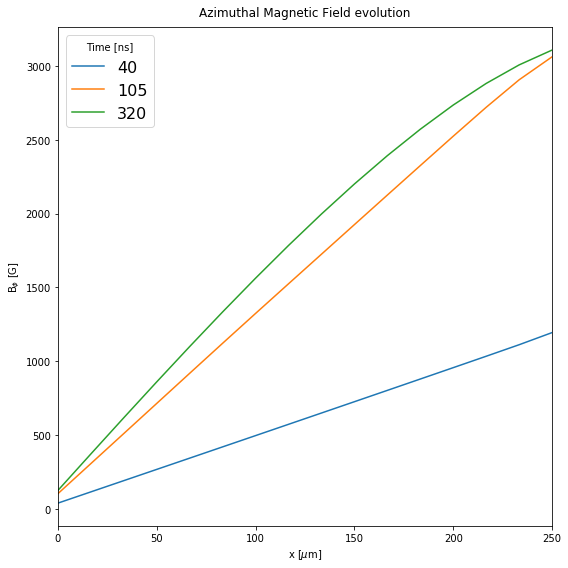

In [9]:
#Basic Example without adjustments

inds = [400,1050,3200]
SVNM = 'poster_3phase-3times'

plot_r_lineouts(inds,'magz',curr_folder,sv=SVNM)

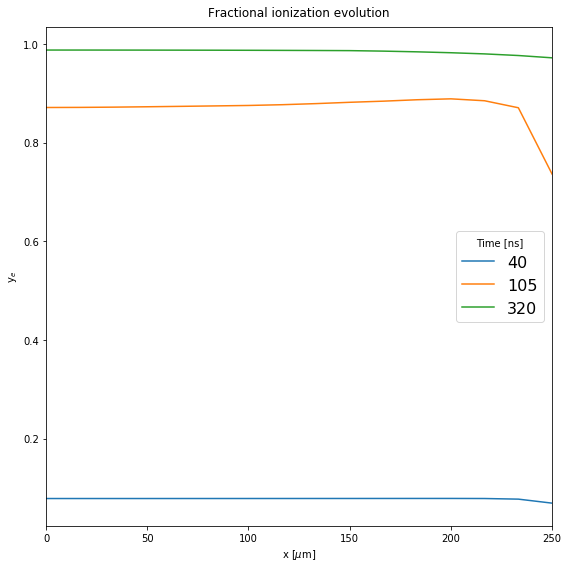

In [10]:
plot_r_lineouts(inds,'ye',curr_folder,sv=SVNM)

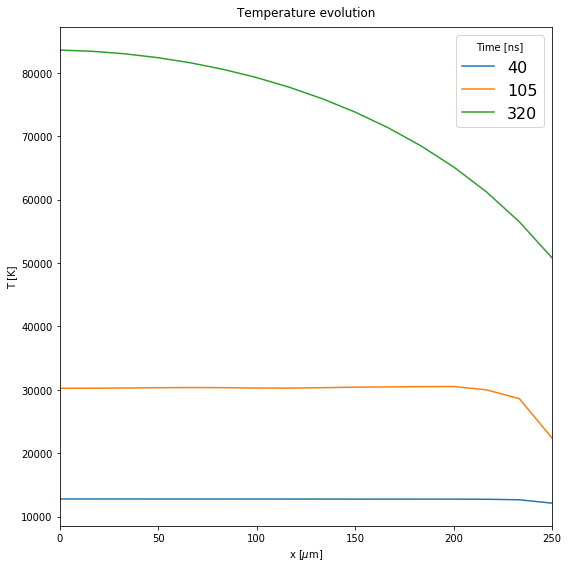

In [11]:
plot_r_lineouts(inds,'tele',curr_folder,sv=SVNM)

### Adjusting the matplotlib parameters

I don't specify many parameters for the plotting, so you can feel free to make adjustments to the `rcParams` before making the plot.

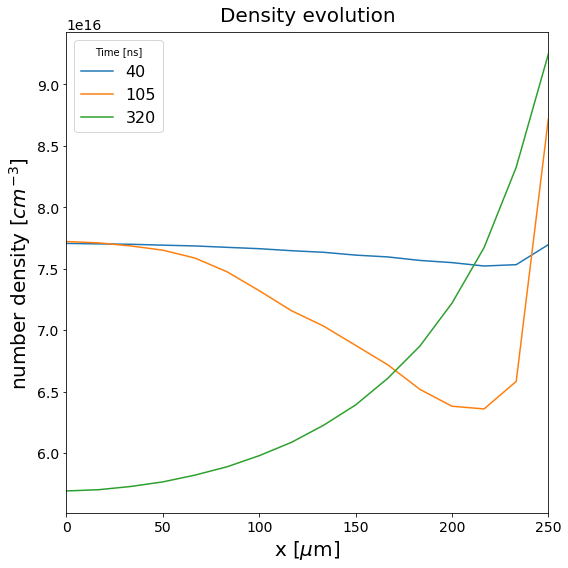

In [12]:
#Example adjusting the plot labels

label_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

title_size = 20
mpl.rcParams['axes.titlesize'] = title_size 
mpl.rcParams['axes.labelsize'] = title_size 

plot_r_lineouts(inds,'dens',curr_folder,sv=SVNM)

## Example Longitudinal Lineout Plots

These aren't very interesting for 2D R-Z geometry with periodic boundaries...

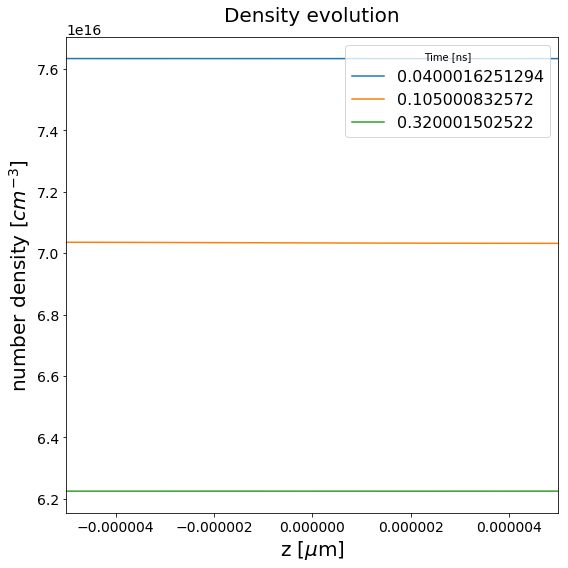

In [13]:
plot_z_lineouts(inds,'dens',curr_folder,sv=SVNM)

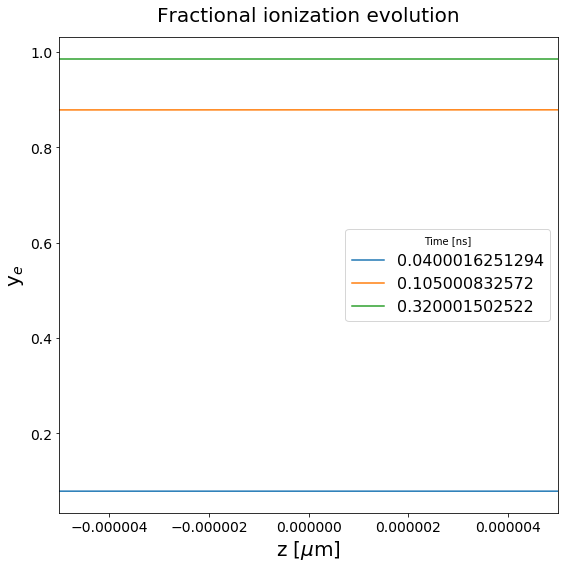

In [14]:
plot_z_lineouts(inds,'ye',curr_folder,sv=SVNM)

## Example 2D Plots

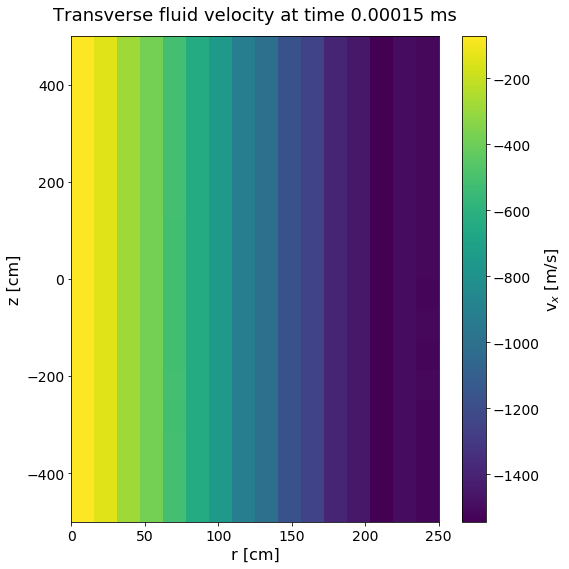

In [15]:
plot_2D(1500,'velx',curr_folder)

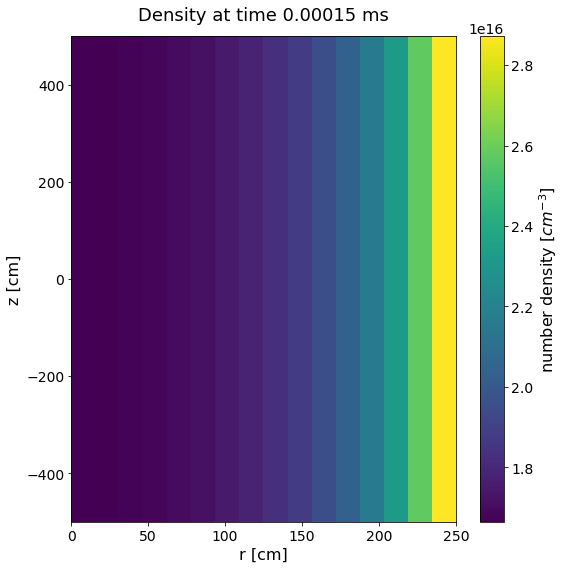

In [16]:
plot_2D(1500,'dens',curr_folder)

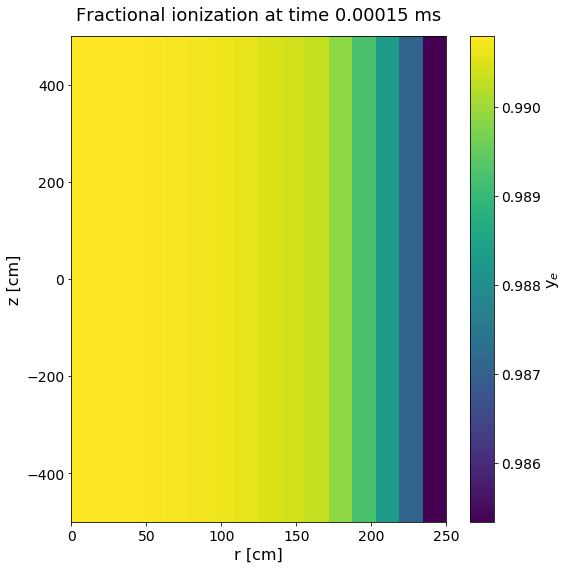

In [17]:
plot_2D(1500,'ye',curr_folder)

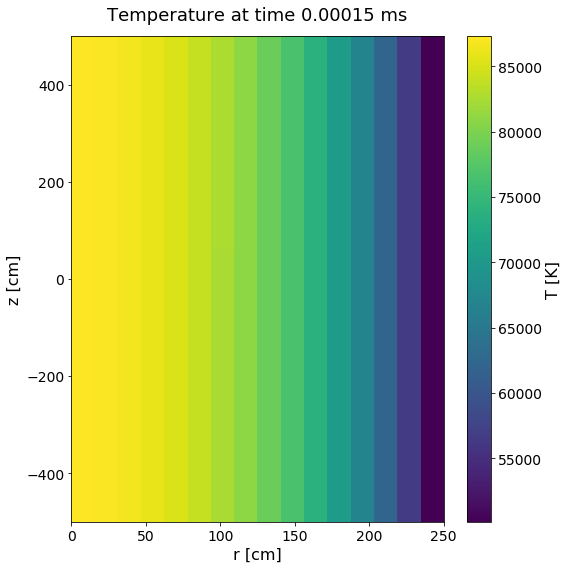

In [18]:
plot_2D(1500,'tele', curr_folder)

## Plotting integrated grid quantities

Integrated quantities are stored every time step within the `.dat` file corresponding to the simulation name. The data file is a simple text file which outputs quantities with the organization as follows:

- column 0: time
- column 1: mass
- column 2: x-momentum
- column 3: y-momentum
- column 4: z-momentum
- column 5: E_total
- column 6: E_kinetic
- column 7: E_internal
- column 8: MagEnergy  

For more information, see [Section 9.2 of the user guide](http://flash.uchicago.edu/site/flashcode/user_support/flash4_ug_4p5/node68.html#SECTION05224000000000000000).

In [19]:
datfile = np.loadtxt('caplinear3.dat')

stride = 100
dat_times = datfile[::stride,0]
dat_mass = datfile[::stride,1]
dat_Etot = datfile[::stride,5]
dat_Mag = datfile[::stride,8]
dat_xmom = datfile[::stride,2]
dat_zmom = datfile[::stride,4]

m0 = dat_mass[0]
E0 = dat_Etot[700]
M0 = dat_Mag[2000]
xmom1 = np.max(dat_xmom)
#zmom0 = dat_zmom[0]

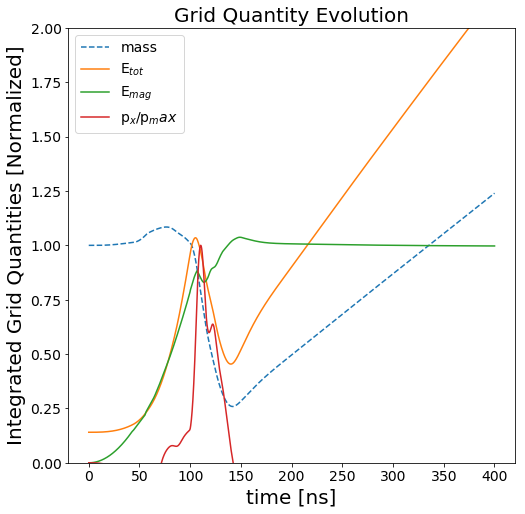

In [20]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.plot(dat_times/1e-9,dat_mass/m0, linestyle='dashed', label = 'mass')
ax.plot(dat_times/1e-9,dat_Etot/E0, label = r'E$_{tot}$')
ax.plot(dat_times/1e-9,dat_Mag/M0, label = r'E$_{mag}$')
ax.plot(dat_times/1e-9,dat_xmom/xmom1, label = r'p$_x$/p$_max$')
#ax.plot(dat_times/1e-9,dat_xmom, label = r'p$_z$')
plt.legend(loc='best',fontsize=14)

ax.set_ylim(0,2)

ax.set_title('Grid Quantity Evolution')

ax.set_ylabel('Integrated Grid Quantities [Normalized]')
ax.set_xlabel('time [ns]')
fig.savefig('grid_quantities_poster.pdf',bbox_inches='tight')